# Chapter 7. Hypothesis and Inference

## Example: Flipping a Coin

In [7]:
from typing import Tuple
import math

def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

In [2]:
# Extracted from Chapter 6. Probability, in order to run the code below.
# Please refer to the notebook for the full chapter content.

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [3]:
# The normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

# It's above the threshold if it's not below the threshold
def normal_probability_above(lo: float,
                             mu: float = 0,
                             sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is greater than lo."""
    return 1 - normal_cdf(lo, mu, sigma)

# It's between if it's less than hi, but not less than lo
def normal_probability_between(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is between lo and hi."""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# It's outside if it's not between
def normal_probability_outside(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is not between lo and hi."""
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [4]:
# Extracted from Chapter 6. Probability, in order to run the code below.
# Please refer to the notebook for the full chapter content.

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # If not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0   # normal_cdf(-10) is (very close to) 0
    hi_z = 10.0     # normal_cdf(10) is (very close to) 1

    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2  # Consider the midpoint
        mid_p = normal_cdf(mid_z)   # and the cdf's value there
        if mid_p < p:
            low_z = mid_z           # Midpoint too low, search above it
        else:
            hi_z = mid_z            # Midpoint too high, search below it

    return mid_z

In [5]:
def normal_upper_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
     """Returns the z for which P(Z >= z) = probability"""
     return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float,
                            mu: float = 0,
                            sigma: float = 1) -> Tuple[float, float]:
    """
    Returns the symmetric (about the mean) bounds
    that contain the specified probability
    """
    tail_probability = (1 - probability) / 2

    # Upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # Lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [10]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

print(mu_0)     # 500.0
print(sigma_0)  # 15.8

500.0
15.811388300841896


<b>Significance</b> - the willingness to make a <i>type 1 error</i> ("false positive")

In [21]:
# (469, 531)
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)

print(lower_bound)  # 469.01
print(upper_bound)  # 530.99

469.01026640487555
530.9897335951244


<b>Power</b> - the probability of not making a <i>type 2 error</i> ("false negative")

In [25]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)                       # (469, 531)

# Actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)                # (550, 15.732132722552274)

# A type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)      # 0.11345199870463285
power = 1 - type_2_probability  # 0.887

power

0.8865480012953671

In [26]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)  # 526.0073585242053
# Is 526 (< 531, since we need more probability in the upper tail)

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)  # 0.06362051966928273
power = 1 - type_2_probability  # 0.936

power

0.9363794803307173

## p-Values

In [27]:
def two_side_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """
    How likely are we to see a value at least as extreme as x (in either
    direction) if our values are from an N(mu, sigma)?
    """
    if x >= mu:
        # x is greater than the mean, so the tail is everything greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # x is less than the mean, so the tail is everything less than x
        return 2 * normal_probability_below(x, mu, sigma)

In [29]:
two_side_p_value(529.5, mu_0, sigma_0)  # 0.062

0.06207721579598835

<div class="alert alert-block alert-info">
<b>Note:</b> A <b><i>Continuity Correction</i></b> reflects the fact that <code>normal_probability_between(529.5, 530.5, mu_0, sigma_0)</code>
is a better estimate of the probability of seeing 530 heads than <code>normal_probability_between(530, 531, mu_0, sigma_0)</code>

Correspondingly, <code>normal_probability_above(529.5, mu_0, sigma_0)</code> is a better estimate of the probability of seeing at least 530 heads.
</div>

In [33]:
import random

extreme_value_count = 0
for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0    # Count # of heads
                    for _ in range(1000))                # in 1000 flips
    if num_heads >= 530 or num_heads <= 470:             # and count how often
        extreme_value_count += 1                         # the # is 'extreme'

# p-value was 0.062 => ~62 extreme values out of 1000
assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

In [34]:
two_side_p_value(531.5, mu_0, sigma_0)  # 0.0463

0.046345287837786575

In [35]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [36]:
upper_p_value(524.5, mu_0, sigma_0)  # 0.0606

0.06062885772582072

In [37]:
upper_p_value(526.5, mu_0, sigma_0)  # 0.0463

0.04686839508859242

## Confidence Intervals

```
math.sqrt(p * (1 - p) / 1000)
```

In [40]:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)  # 0.0158

sigma

0.015791611697353755

In [41]:
normal_two_sided_bounds(0.95, mu, sigma)  # [0.4940, 0.5560]

(0.4940490278129096, 0.5559509721870904)

In [42]:
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)  # 0.0158
normal_two_sided_bounds(0.95, mu, sigma)  # [0.5091, 0.5709]

(0.5091095927295919, 0.5708904072704082)

## p-Hacking

In [43]:
from typing import List

def run_experiment() -> List[bool]:
    """Flips a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment: List[bool]) -> bool:
    """Using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

assert num_rejections == 46

## Example: Running an A/B Test

In [44]:
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [47]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [49]:
z = a_b_test_statistic(1000, 200, 1000, 180)  # -1.14

z

-1.1403464899034472

In [50]:
two_side_p_value(z)  # 0.254

0.254141976542236

In [51]:
z = a_b_test_statistic(1000, 200, 1000, 150)  # -2.94
two_side_p_value(z)  # 0.003

0.003189699706216853

## Bayesian Inference

In [52]:
def B(alpha: float, beta: float) -> float:
    """A normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:          # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

In [53]:
alpha = 1
beta = 1

alpha / (alpha + beta)  # 0.2

0.5

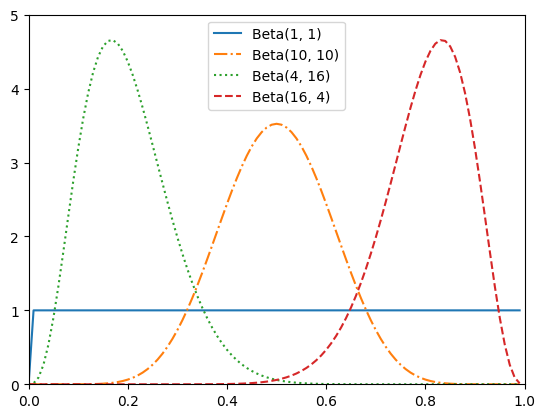

In [61]:
from matplotlib import pyplot as plt

xs = [x / 100.0 for x in range(100)]

plt.plot(xs, [beta_pdf(x, alpha, beta) for x in xs], '-', label='Beta(1, 1)')
plt.plot(xs, [beta_pdf(x, 10, 10) for x in xs], '-.', label='Beta(10, 10)')
plt.plot(xs, [beta_pdf(x, 4, 16) for x in xs], ':', label='Beta(4, 16)')
plt.plot(xs, [beta_pdf(x, 16, 4) for x in xs], '--', label='Beta(16, 4)')

plt.xlim(0, 1)
plt.ylim(0, 5)

plt.legend()
plt.show()

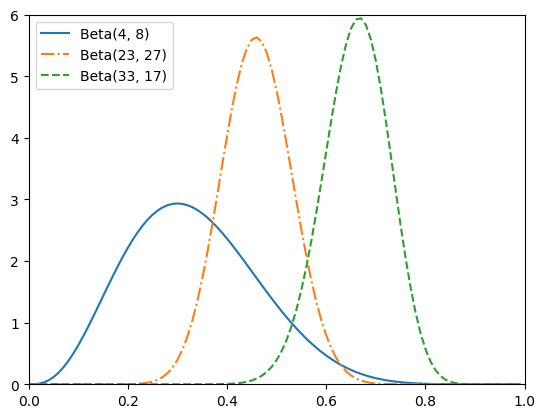

In [62]:
xs = [x / 100.0 for x in range(100)]

plt.plot(xs, [beta_pdf(x, 4, 8) for x in xs], '-', label='Beta(4, 8)')
plt.plot(xs, [beta_pdf(x, 23, 27) for x in xs], '-.', label='Beta(23, 27)')
plt.plot(xs, [beta_pdf(x, 33, 17) for x in xs], '--', label='Beta(33, 17)')

plt.xlim(0, 1)
plt.ylim(0, 6)

plt.legend()
plt.show()